In [99]:
import numpy as np
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from matplotlib import rcParams


plt.rcParams['figure.figsize'] = [12,6]
plt.rcParams.update({'font.size': 18})

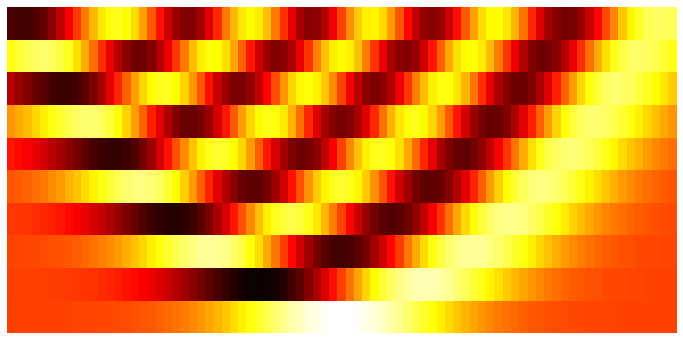

In [73]:
L = 10 # define domain
x2 = np.arange(-L,L,0.1) 
n = len(x2)
k = n*(2*np.pi/(2*L))*np.fft.fftfreq(n) # k-vector
ye = np.exp(-np.power(x2,2))
ye2 = np.exp(np.power(x2,2)/2) # define Gaussians

y = np.zeros((n,10))

for jj in range(10): # loop through 10 modes
    # 2nd derivative
    yd = np.real(np.fft.ifft((np.power((1j)*k,jj))*np.fft.fft(ye)))
    
    mode = np.power(-1,jj) * \
        np.power((np.power(2,jj)*np.math.factorial(jj)*np.sqrt(np.pi)),-0.5) * \
        ye2 * yd
            
    y[:,jj] = mode # store modes as columns
            
x = x2[int(n/2)-40 : int(n/2)+41] # keep only -4<x<4
yharm = y[int(n/2)-40 : int(n/2)+41,:]

plt.pcolor(np.flipud(np.rot90(yharm)),cmap='hot')
plt.axis(False)
plt.show()

Conditioning number of M: 1.3246319606938588
Conditioning number of M1: 5.69525884754259
Conditioning number of M2: 23.751581168729935
Conditioning number of M3: 2352.0318433984567


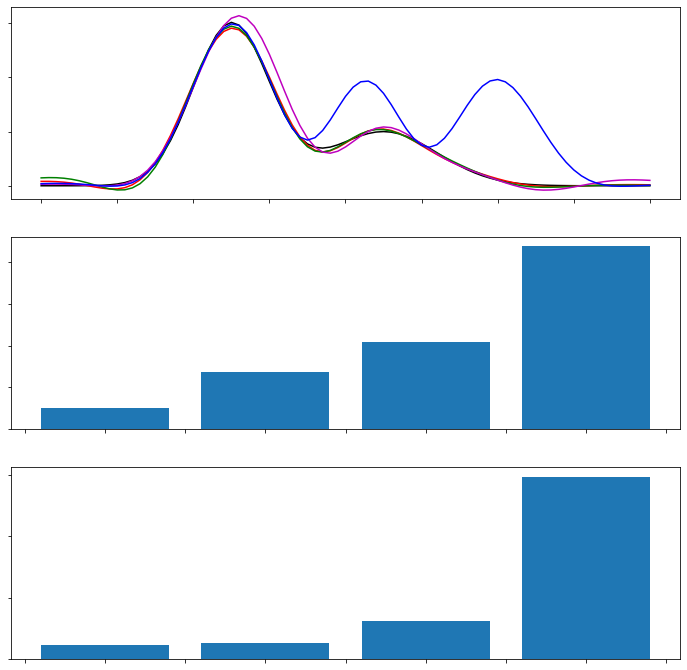

In [140]:
plt.rcParams['figure.figsize'] = [12,12]
fig, axs = plt.subplots(3,1)

n = len(x)
f = np.exp(-np.power(x-0.5,2)) + 3*np.exp(-2*np.power(x+1.5,2))
axs[0].plot(x,f,'k')
Err = np.zeros(4)

a = np.zeros(10)

for jj in range(10):
    a[jj] = np.trapz(f*yharm[:,jj],x)

f2 = yharm @ a
axs[0].plot(x,f2,'r')
Err[0] = np.linalg.norm(f2-f) # recontruction error
    
M = np.zeros((10,10))

for jj in range(10): # matrix M reconstruction
    for kk in range(jj+1):
        Area = np.trapz(yharm[:,jj]*yharm[:,kk],x)
        M[jj,kk] = Area
        M[kk,jj] = Area
        
print('Conditioning number of M: {}'.format(np.linalg.cond(M)))

color_list = ['g','m','b']
MJ = np.zeros((10,10,3))
condJ = np.zeros(3)
sJ = np.zeros((3,n))
for jloop in range(3):
    s = (np.random.rand(n) > 0.8) # grab 20% random measurements
    sJ[jloop,:] = s
    # construct M_j
    M2 = np.zeros((10,10))
    for jj in range(10):
        for kk in range(jj+1):
            Area = np.trapz(s*yharm[:,jj]*yharm[:,kk],x)
            M2[jj,kk] = Area
            M2[kk,jj] = Area
    MJ[:,:,jloop] = M2
    condJ[jloop] = np.linalg.cond(M2)
    print('Conditioning number of M{}: {}'.format((jloop+1),np.linalg.cond(M2)))

    
    ftild = np.zeros(10)
    for jj in range(10): # reconstruction using gappy
        ftild[jj] = np.trapz(s*f*yharm[:,jj],x)
    
    atild = np.linalg.solve(M2,ftild) # compute error
    f2 = yharm @ atild
    axs[0].plot(x,f2,color=color_list[jloop])
    Err[jloop+1] = np.linalg.norm(f2-f)
    
con2 = np.concatenate(([1],condJ))
axs[1].bar(range(len(con2)),np.log(con2)+1)
axs[2].bar(range(len(Err)),Err)

for ax in axs:
    ax.set_xticklabels([''])
    ax.set_yticklabels([''])

plt.show()

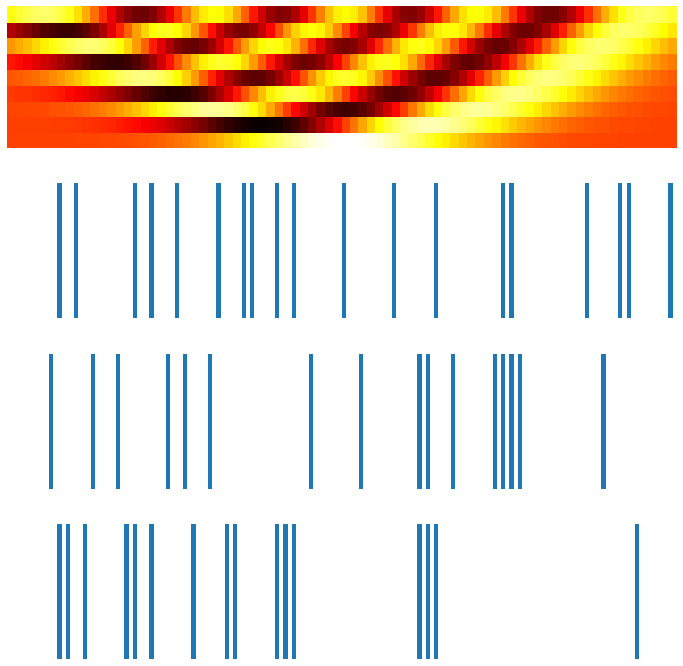

In [156]:
plt.rcParams['figure.figsize'] = [12,12]
fig,axs = plt.subplots(4,1)
axs[0].pcolor(x,range(10),np.flipud(np.rot90(yharm)),cmap='hot')
for jloop in range(3):
    axs[jloop+1].bar(x,sJ[jloop,:],align='edge', width=0.05)
    axs[jloop+1].set_xlim(x[0],x[-1])
for ax in axs:
    ax.axis(False)
plt.show()

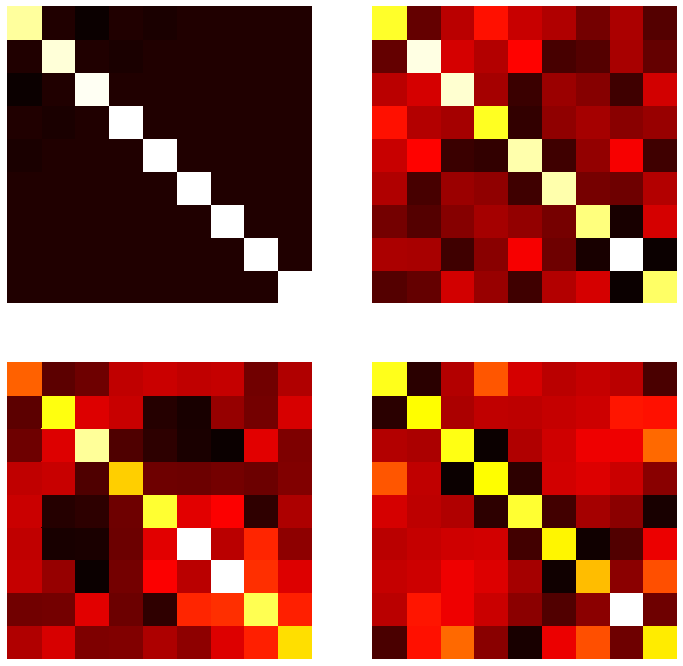

In [157]:
fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)
axs[0].pcolor(np.arange(10,0,-1),np.arange(0,10),M.T,cmap='hot')

for jloop in range(3):
    axs[jloop+1].pcolor(np.arange(10,0,-1),np.arange(0,10),np.squeeze(MJ[:,:,jloop]).T,cmap='hot')
    
for ax in axs:
    ax.axis(False)

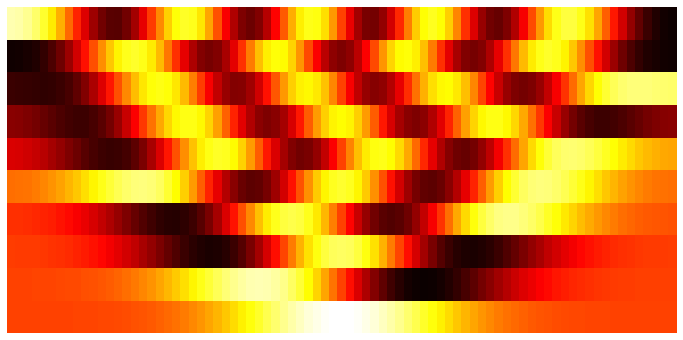

In [159]:
plt.rcParams['figure.figsize'] = [12,6]
L = 4
x = np.arange(-L,L+0.1,0.1)
n = len(x)
dx = x[1]-x[0]
A = np.zeros((n-2,n-2))
for jj in range(n-2):
    A[jj,jj] = -2 -(dx**2)*x[jj+1]**2
    
for jj in range(n-3):
    A[jj+1,jj] = 1
    A[jj,jj+1] = 1
    
A[0,0] = A[0,0]+4/3
A[0,1] = A[0,1]-1/3
A[-1,-1] = A[-1,-1]+4/3
A[-1,-2] = A[-1,-2]-1/3

D, V3 = linalg.eigs(-A,10,which='SR') # 10 eigenvalues with the smallest real parts

V2 = np.row_stack(((4/3)*V3[0,:]-(1/3)*V3[1,:] , V3 , (4/3)*V3[-1,:]-(1/3)*V3[-2,:]))
V = np.zeros_like(V2)

for jj in range(10):
    V[:,jj] = V2[:,jj]/np.sqrt(np.trapz(np.power(V2[:,jj],2),x))
    
sort_ind = np.argsort(D/dx**2)
Esolb = D[sort_ind]/dx**2

ysolb = np.zeros_like(V)

for jj in range(10):
    ysolb[:,jj] = V[:,sort_ind[jj]]
    
plt.pcolor(-np.real(np.flipud(np.rot90(ysolb))),cmap='hot')
plt.axis(False)
plt.show()